https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [1]:
import gpytorch
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from utils.metrics import MetricsLogger
from utils.data_loaders import get_wake_dataloaders
#from utils.evaluation import test_pytorch_model

In [2]:
FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"data/{FACTORS_FOLDER}/"
INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR = {'ti': 4, 'ct': 4}
train_reduc_factor_string = "training_factors=" + "-".join([f"{k}{v}" for k, v in INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR.items()])
MODEL_NAME = f"multivariate_GP_ExactGP_{train_reduc_factor_string}"
BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
CONSIDER_WS = False
COORDS_AS_INPUT = False # multivariate setting
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
    FACTORS_FOLDER = FACTORS_FOLDER.replace("TIstep0.01_CTstep0.01", "reducedTI-CT")
    BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"

MODEL_DESCRIPTION = f"{MODEL_NAME}_{FACTORS_FOLDER} standard multivariate GP" #TODO
print(f"Model description: {MODEL_DESCRIPTION}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{DEVICE=}")

# hyperparameters
EPOCHS = 50
LR = 0.1
BATCH_SIZE = 4

Model description: multivariate_GP_ExactGP_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01 standard multivariate GP
DEVICE=device(type='cpu')


In [3]:
valid_dataloader = None
train_dataloader, valid_dataloader, test_dataloader = get_wake_dataloaders(DATA_FOLDER,
                                                          consider_ws=CONSIDER_WS,
                                                          coords_as_input=COORDS_AS_INPUT,
                                                          #train_perc=0.6,
                                                          #test_perc=0.2,
                                                          #validation_perc=0.2,
                                                          input_var_to_train_reduction_factor=INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR,
                                                          batch_size=BATCH_SIZE)

print(len(train_dataloader))

train_x, train_y = train_dataloader.dataset.inputs, train_dataloader.dataset.outputs
print("Train shapes: ", train_x.shape, train_y.shape)

"""
if valid_dataloader is not None:
    valid_x, valid_y = valid_dataloader.dataset.inputs, valid_dataloader.dataset.outputs
    print("Valid shapes: ", valid_x.shape, valid_y.shape)
"""

grid_size = train_dataloader.dataset.num_cells
print(f"{grid_size=}")

/Users/niccolomorabito/Library/CloudStorage/GoogleDrive-morabito.1808746@studenti.uniroma1.it/My Drive/BDMA/Semester4 Thesis/Ainslie-surrogate/utils/data_loaders.py:248: UserWarning: 
Ignoring percentages of train-valid-test split (train_perc=0.8, valid_perc=0, test_perc=0.2)
and using the reduction factors for the training set instead:
{'ti': 4, 'ct': 4}
  warnings.warn(


138
Train shapes:  torch.Size([550, 2]) torch.Size([550, 7168])
grid_size=7168


In [4]:
"""
REDUCE THE AMOUNT OF DATA
num_instances = 10 #TODO
train_x= torch.split(train_x, num_instances)[0]#.reshape(num_instances, grid_size, num_features)
train_y = torch.split(train_y,num_instances)[0]#.reshape(num_instances, grid_size)
print(train_x.shape, train_y.shape)"""

'\nREDUCE THE AMOUNT OF DATA\nnum_instances = 10 #TODO\ntrain_x= torch.split(train_x, num_instances)[0]#.reshape(num_instances, grid_size, num_features)\ntrain_y = torch.split(train_y,num_instances)[0]#.reshape(num_instances, grid_size)\nprint(train_x.shape, train_y.shape)'

# Sklearn

In [5]:
"""
kernel = RBF(length_scale=1.0)
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(train_x, train_y)
"""

'\nkernel = RBF(length_scale=1.0)\ngp = GaussianProcessRegressor(kernel=kernel)\ngp.fit(train_x, train_y)\n'

# Gpytorch

In [5]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=grid_size
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=grid_size, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=grid_size)
model = MultitaskGPModel(train_x, train_y, likelihood)

Logging multivariate_GP_ExactGP_training_factors=ti4-ct4
Epoch 0 ->	Training loss=1.097070574760437	epoch_time (seconds)=218	
Epoch 1 ->	Training loss=1.0599368810653687	epoch_time (seconds)=219	
Epoch 2 ->	Training loss=1.0220731496810913	epoch_time (seconds)=216	
Epoch 3 ->	Training loss=0.9834858179092407	epoch_time (seconds)=220	
Epoch 4 ->	Training loss=0.9441713094711304	epoch_time (seconds)=197	
Epoch 5 ->	Training loss=0.9041345715522766	epoch_time (seconds)=214	
Epoch 6 ->	Training loss=0.8633858561515808	epoch_time (seconds)=240	
Epoch 7 ->	Training loss=0.821935772895813	epoch_time (seconds)=242	
Epoch 8 ->	Training loss=0.7797961235046387	epoch_time (seconds)=196	
Epoch 9 ->	Training loss=0.7369829416275024	epoch_time (seconds)=211	
Epoch 10 ->	Training loss=0.6935153603553772	epoch_time (seconds)=204	
Epoch 11 ->	Training loss=0.6494133472442627	epoch_time (seconds)=209	
Epoch 12 ->	Training loss=0.6046971678733826	epoch_time (seconds)=213	
Epoch 13 ->	Training loss=0.5593

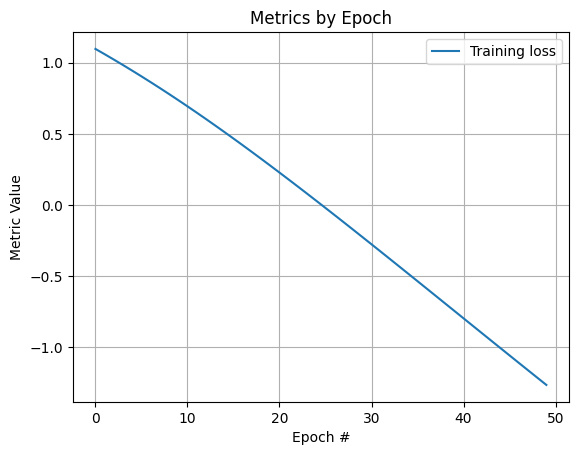

Metrics exported in the following csv file: logged_metrics/multivariate_GP_ExactGP_training_factors=ti4-ct4_27-06-2023_17-10-13.csv


In [7]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

metrics_logger = MetricsLogger(name=MODEL_NAME, automatic_save_after=5)
best_tloss = 1_000_000.
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    if torch.isnan(loss): #TODO fix or delete
        print("nan loss")
        break
    loss.backward()
    loss_value = loss.item()
    metrics_logger.log_metric(epoch, 'Training loss', loss_value)
    if loss_value < best_tloss:
        best_tloss = loss_value
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    optimizer.step()

metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

In [6]:
# loading best model
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=grid_size)
model = MultitaskGPModel(train_x, train_y, likelihood).to(DEVICE) #ricreating the model by using train_x and train_y as done in https://docs.gpytorch.ai/en/stable/examples/00_Basic_Usage/Saving_and_Loading_Models.html
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()
likelihood.eval()





"""
test_gpytorch_model(model, ,
                   model_description="multivariate GP", #TODO
                   save_results=False)
"""

'\ntest_gpytorch_model(model, ,\n                   model_description="multivariate GP", #TODO\n                   save_results=False)\n'

In [7]:
del train_dataloader, train_x, train_y

test_x, test_y = test_dataloader.dataset.inputs, test_dataloader.dataset.outputs
print("Test shapes: ", test_x.shape, test_y.shape)

"""
REDUCE TEST DATA
test_x_= torch.split(test_x, 10)[0]#.reshape(num_instances, grid_size, num_features)
test_y_= torch.split(test_y, 10)[0]#.reshape(num_instances, grid_size)
print(test_x.shape, test_y.shape)
print(test_x_.shape, test_y_.shape)
"""

Test shapes:  torch.Size([4025, 2]) torch.Size([4025, 7168])


'\nREDUCE TEST DATA\ntest_x_= torch.split(test_x, 10)[0]#.reshape(num_instances, grid_size, num_features)\ntest_y_= torch.split(test_y, 10)[0]#.reshape(num_instances, grid_size)\nprint(test_x.shape, test_y.shape)\nprint(test_x_.shape, test_y_.shape)\n'

In [8]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    print(test_x.shape)
    a = model(test_x)
a

torch.Size([4025, 2])


: 

: 

In [ ]:
"""
# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')
"""